# Preprocess drprnull_42D  

In [1]:
!python --version

Python 3.12.2


## Load required packages 

In [46]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi
from scipy.sparse import csr_matrix
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


In [3]:
sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


## Read 10x Cellranger 7 counts matrix as anndata 

In [6]:

## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
inputpath = basepath.joinpath('analysis','cellranger')
outputpath = basepath.joinpath('analysis','preprocess')
outputfile = basepath.joinpath('analysis','preprocess','drprnull_42D.h5ad')


In [52]:
## Read in count matrix
drprnull_42d = sc.read_10x_mtx(
    inputpath.joinpath('drprnull_42D','outs','filtered_feature_bc_matrix'),
    var_names="gene_symbols",  
    cache=True)


... reading from cache file cache/projectnb-mccall-sbandyadka-drpr42d_snrnaseq-analysis-cellranger-drprnull_42D-outs-filtered_feature_bc_matrix-matrix.h5ad


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Calculate qc metrics

In [53]:
drprnull_42d.var_names_make_unique()
drprnull_42d.var["mt"] = drprnull_42d.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    drprnull_42d, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [32]:
drprnull_42d ## 7674 cells, 16507 genes 

AnnData object with n_obs × n_vars = 7674 × 16507
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

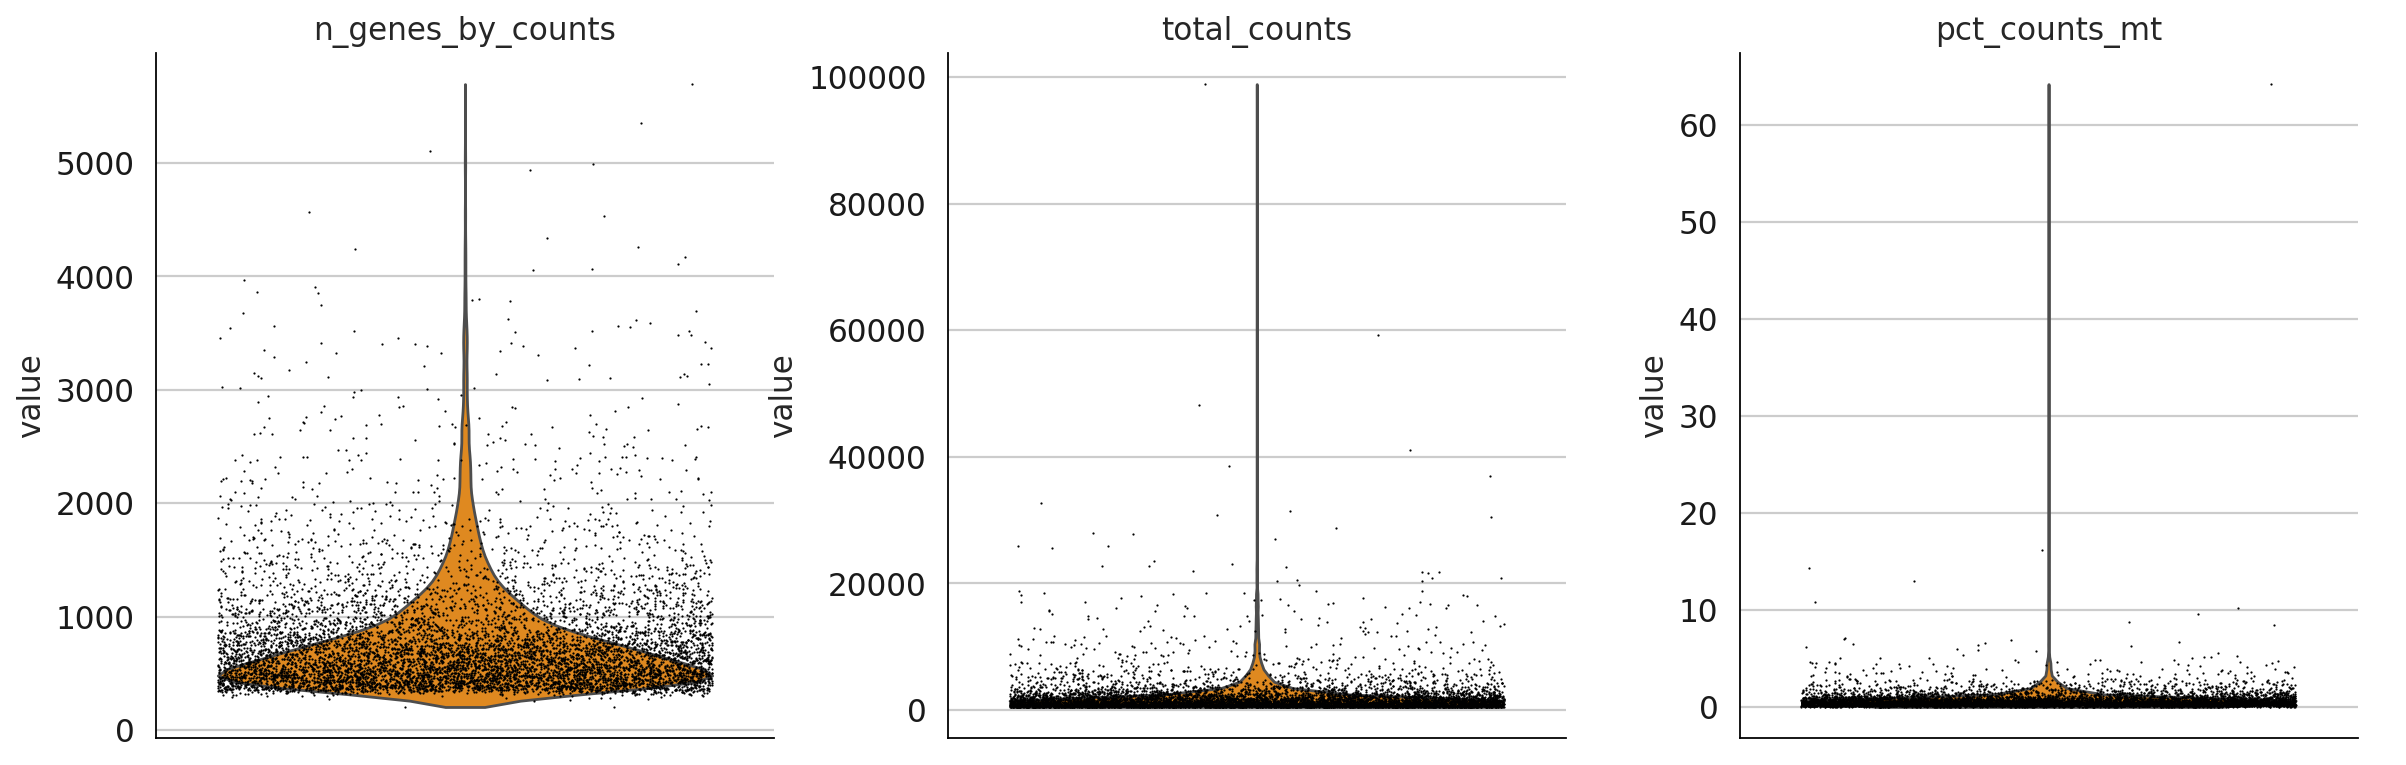

In [33]:
sc.pl.violin(
    drprnull_42d,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,color="darkorange"
)


In [54]:
sc.pp.filter_cells(drprnull_42d, min_genes=200)
sc.pp.filter_genes(drprnull_42d, min_cells=3)

filtered out 4604 genes that are detected in less than 3 cells


<Axes: xlabel='total_counts', ylabel='pct_counts_mt'>

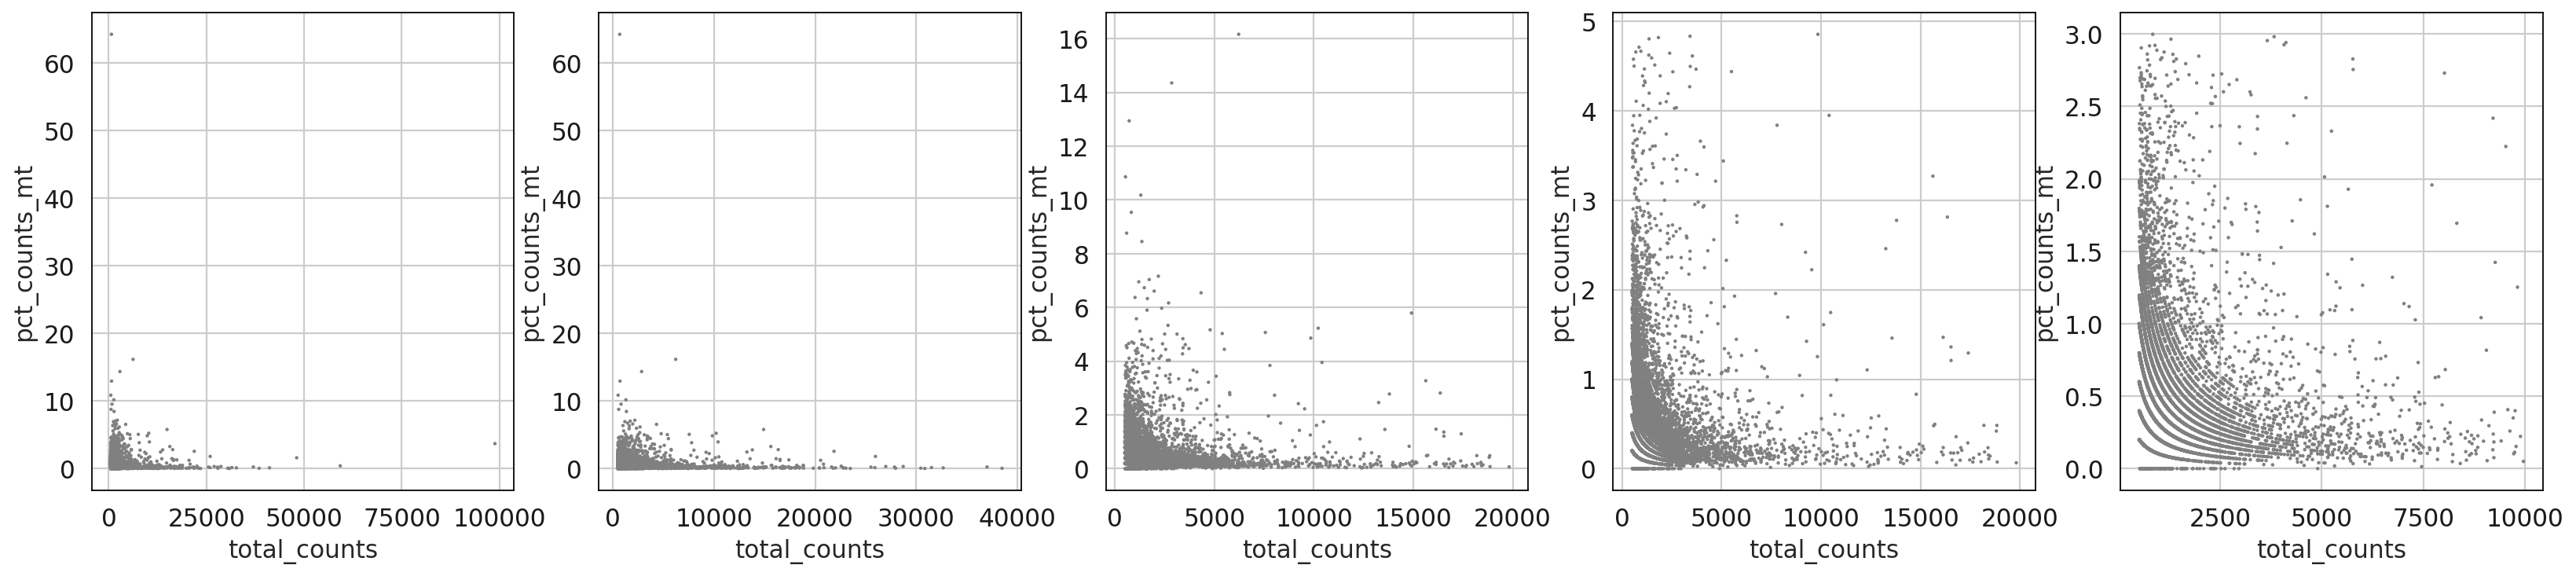

In [83]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sc.pl.scatter(drprnull_42d, x="total_counts", y="pct_counts_mt", show=False, ax=axes[0])
countlt40k = drprnull_42d[drprnull_42d.obs.total_counts < 40000, :].copy()
sc.pl.scatter(countlt40k, x="total_counts", y="pct_counts_mt", show=False, ax=axes[1])

countlt20k_mtlt20 = drprnull_42d[drprnull_42d.obs.pct_counts_mt<20,:].copy()
countlt20k_mtlt20   = countlt20k_mtlt20[countlt20k_mtlt20.obs.total_counts < 20000, :].copy()
sc.pl.scatter(countlt20k_mtlt20, x="total_counts", y="pct_counts_mt", show=False, ax=axes[2])

countlt20k_mtlt5 = drprnull_42d[drprnull_42d.obs.pct_counts_mt<5,:].copy()
countlt20k_mtlt5   = countlt20k_mtlt5[countlt20k_mtlt5.obs.total_counts < 20000, :].copy()
sc.pl.scatter(countlt20k_mtlt5, x="total_counts", y="pct_counts_mt", show=False, ax=axes[3])

countlt10k_mtlt3 = drprnull_42d[drprnull_42d.obs.pct_counts_mt<3,:].copy()
countlt10k_mtlt3   = countlt10k_mtlt3[countlt10k_mtlt3.obs.total_counts < 10000, :].copy()
sc.pl.scatter(countlt10k_mtlt3, x="total_counts", y="pct_counts_mt", show=False, ax=axes[4])


<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

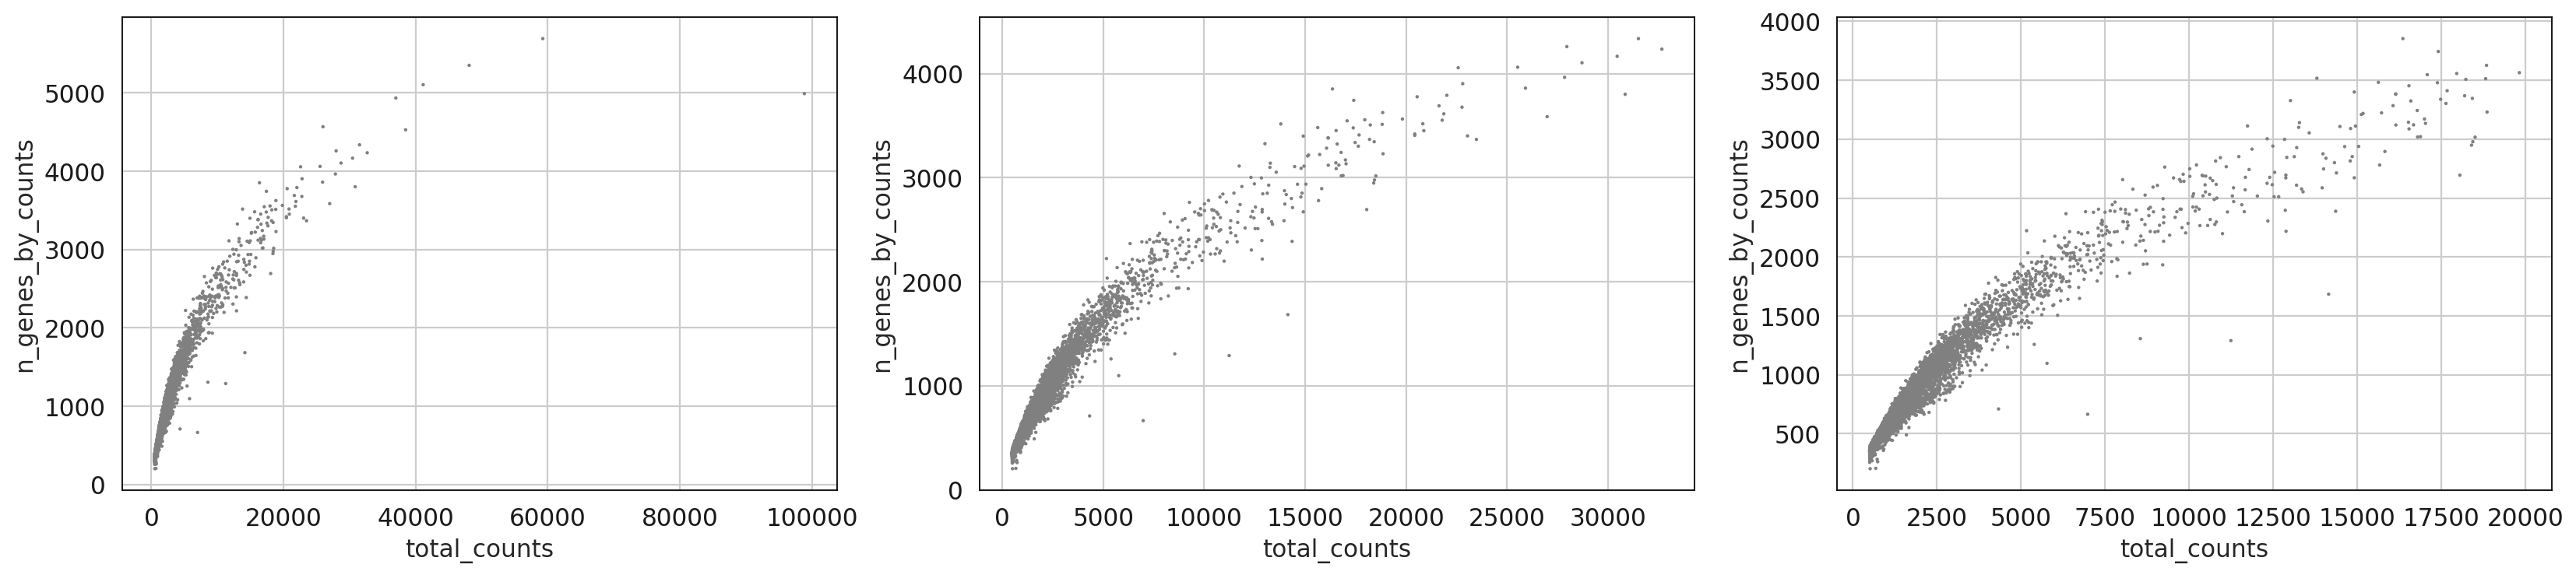

In [86]:
fig, axes = plt.subplots(1,3, figsize=(25,5))
sc.pl.scatter(drprnull_42d, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[0])
ngeneslt4500 = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 4500, :] 
sc.pl.scatter(ngeneslt4500, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[1])
ngeneslt4000_countslt2000 = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 4000, :] 
ngeneslt4000_countslt2000 = ngeneslt4000_countslt2000[ngeneslt4000_countslt2000.obs.total_counts < 20000, :] 
sc.pl.scatter(ngeneslt4000_countslt2000, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[2])

## Filter cells

In [88]:
drprnull_42d = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 4000, :] 
drprnull_42d   = drprnull_42d[drprnull_42d.obs.pct_counts_mt <5,:].copy()
drprnull_42d   = drprnull_42d[drprnull_42d.obs.total_counts <20000,:].copy()

## Normalize and transform counts

In [89]:
sc.pp.normalize_total(drprnull_42d, target_sum=1e4) ## 10,000 reads per cell

normalizing counts per cell
    finished (0:00:00)


In [91]:
sc.pp.log1p(drprnull_42d)

In [92]:
sc.pp.highly_variable_genes(drprnull_42d, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


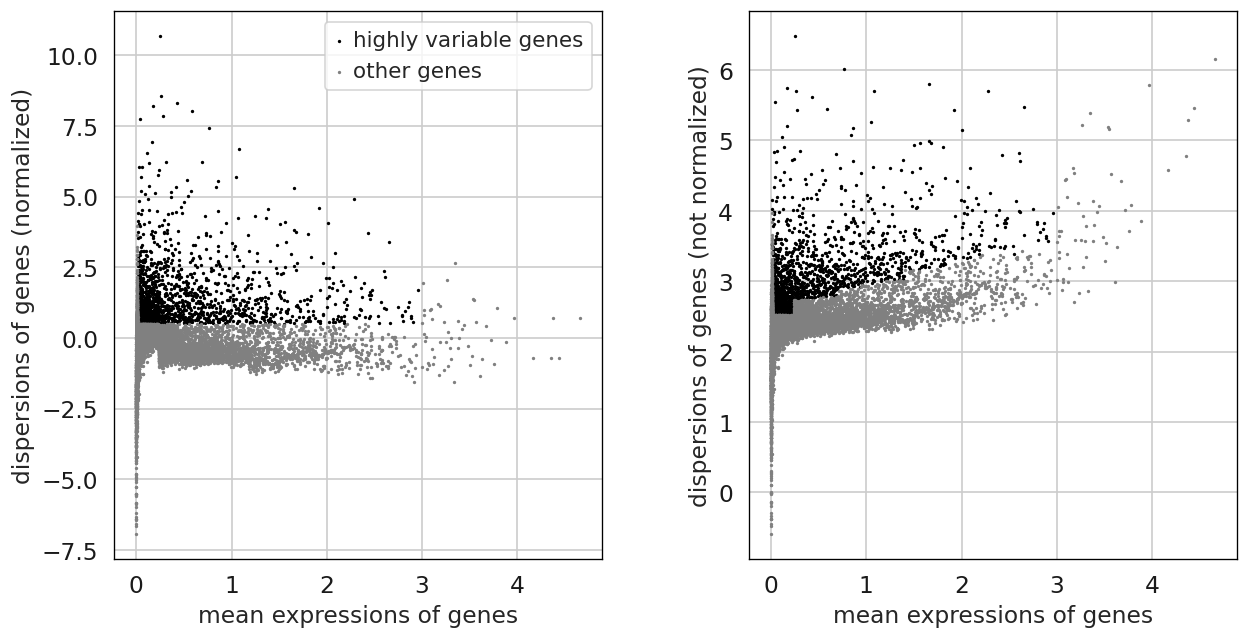

In [104]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": (60)}):
    sc.pl.highly_variable_genes(drprnull_42d)

In [105]:
drprnull_42d.raw = drprnull_42d

## Dimension reduction

In [106]:
sc.tl.pca(drprnull_42d, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


<Axes: title={'center': 'drpr'}, xlabel='PC1', ylabel='PC2'>

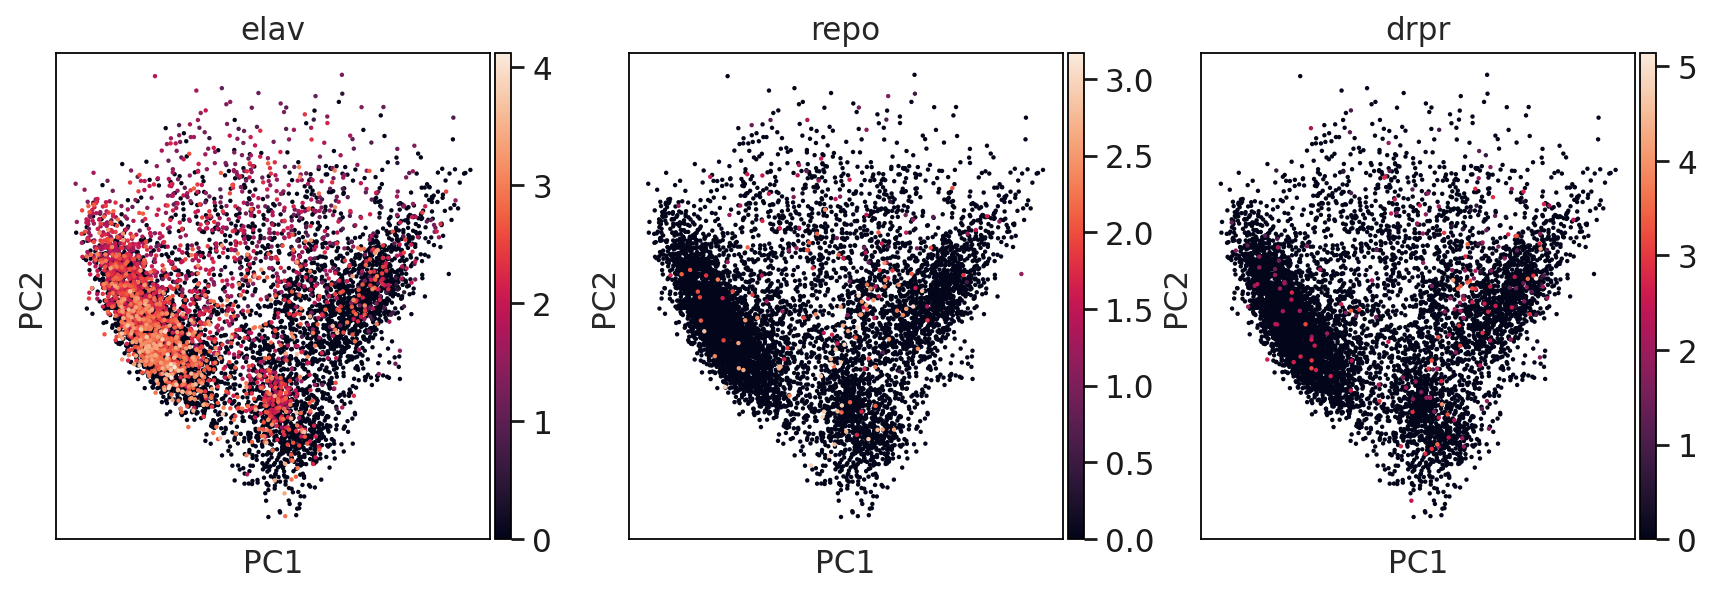

In [115]:
fig,ax= plt.subplots(1,3,figsize=(13,4))
sc.pl.pca(drprnull_42d, color="elav",show=False,ax=ax[0])
sc.pl.pca(drprnull_42d, color="repo",show=False,ax=ax[1])
sc.pl.pca(drprnull_42d, color="drpr",show=False,ax=ax[2])

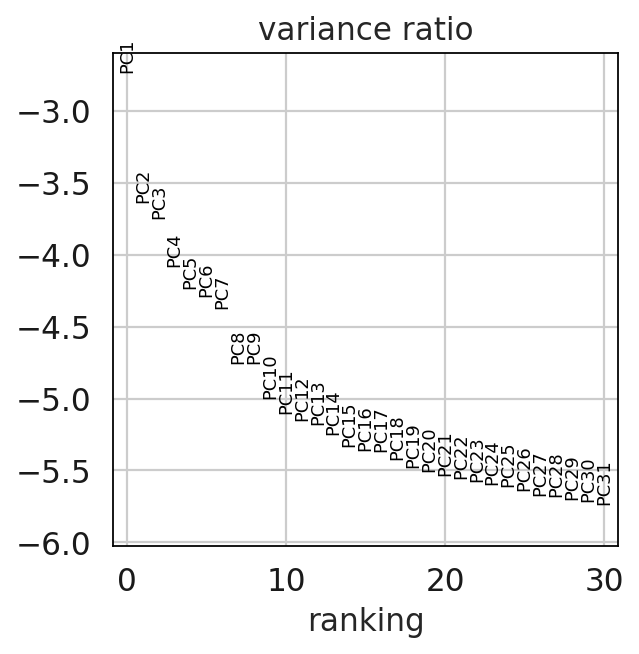

In [116]:
sc.pl.pca_variance_ratio(drprnull_42d, log=True)

In [117]:
drprnull_42d.write(outputfile)

In [118]:
drprnull_42d

AnnData object with n_obs × n_vars = 7613 × 11903
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [119]:
sc.pp.neighbors(drprnull_42d, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [139]:
sc.tl.leiden(
    drprnull_42d,
    resolution=0.05,
    random_state=0,
    n_iterations=20,
    directed=False,
)


running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [140]:
sc.tl.paga(drprnull_42d)
sc.pl.paga(drprnull_42d, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(drprnull_42d, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


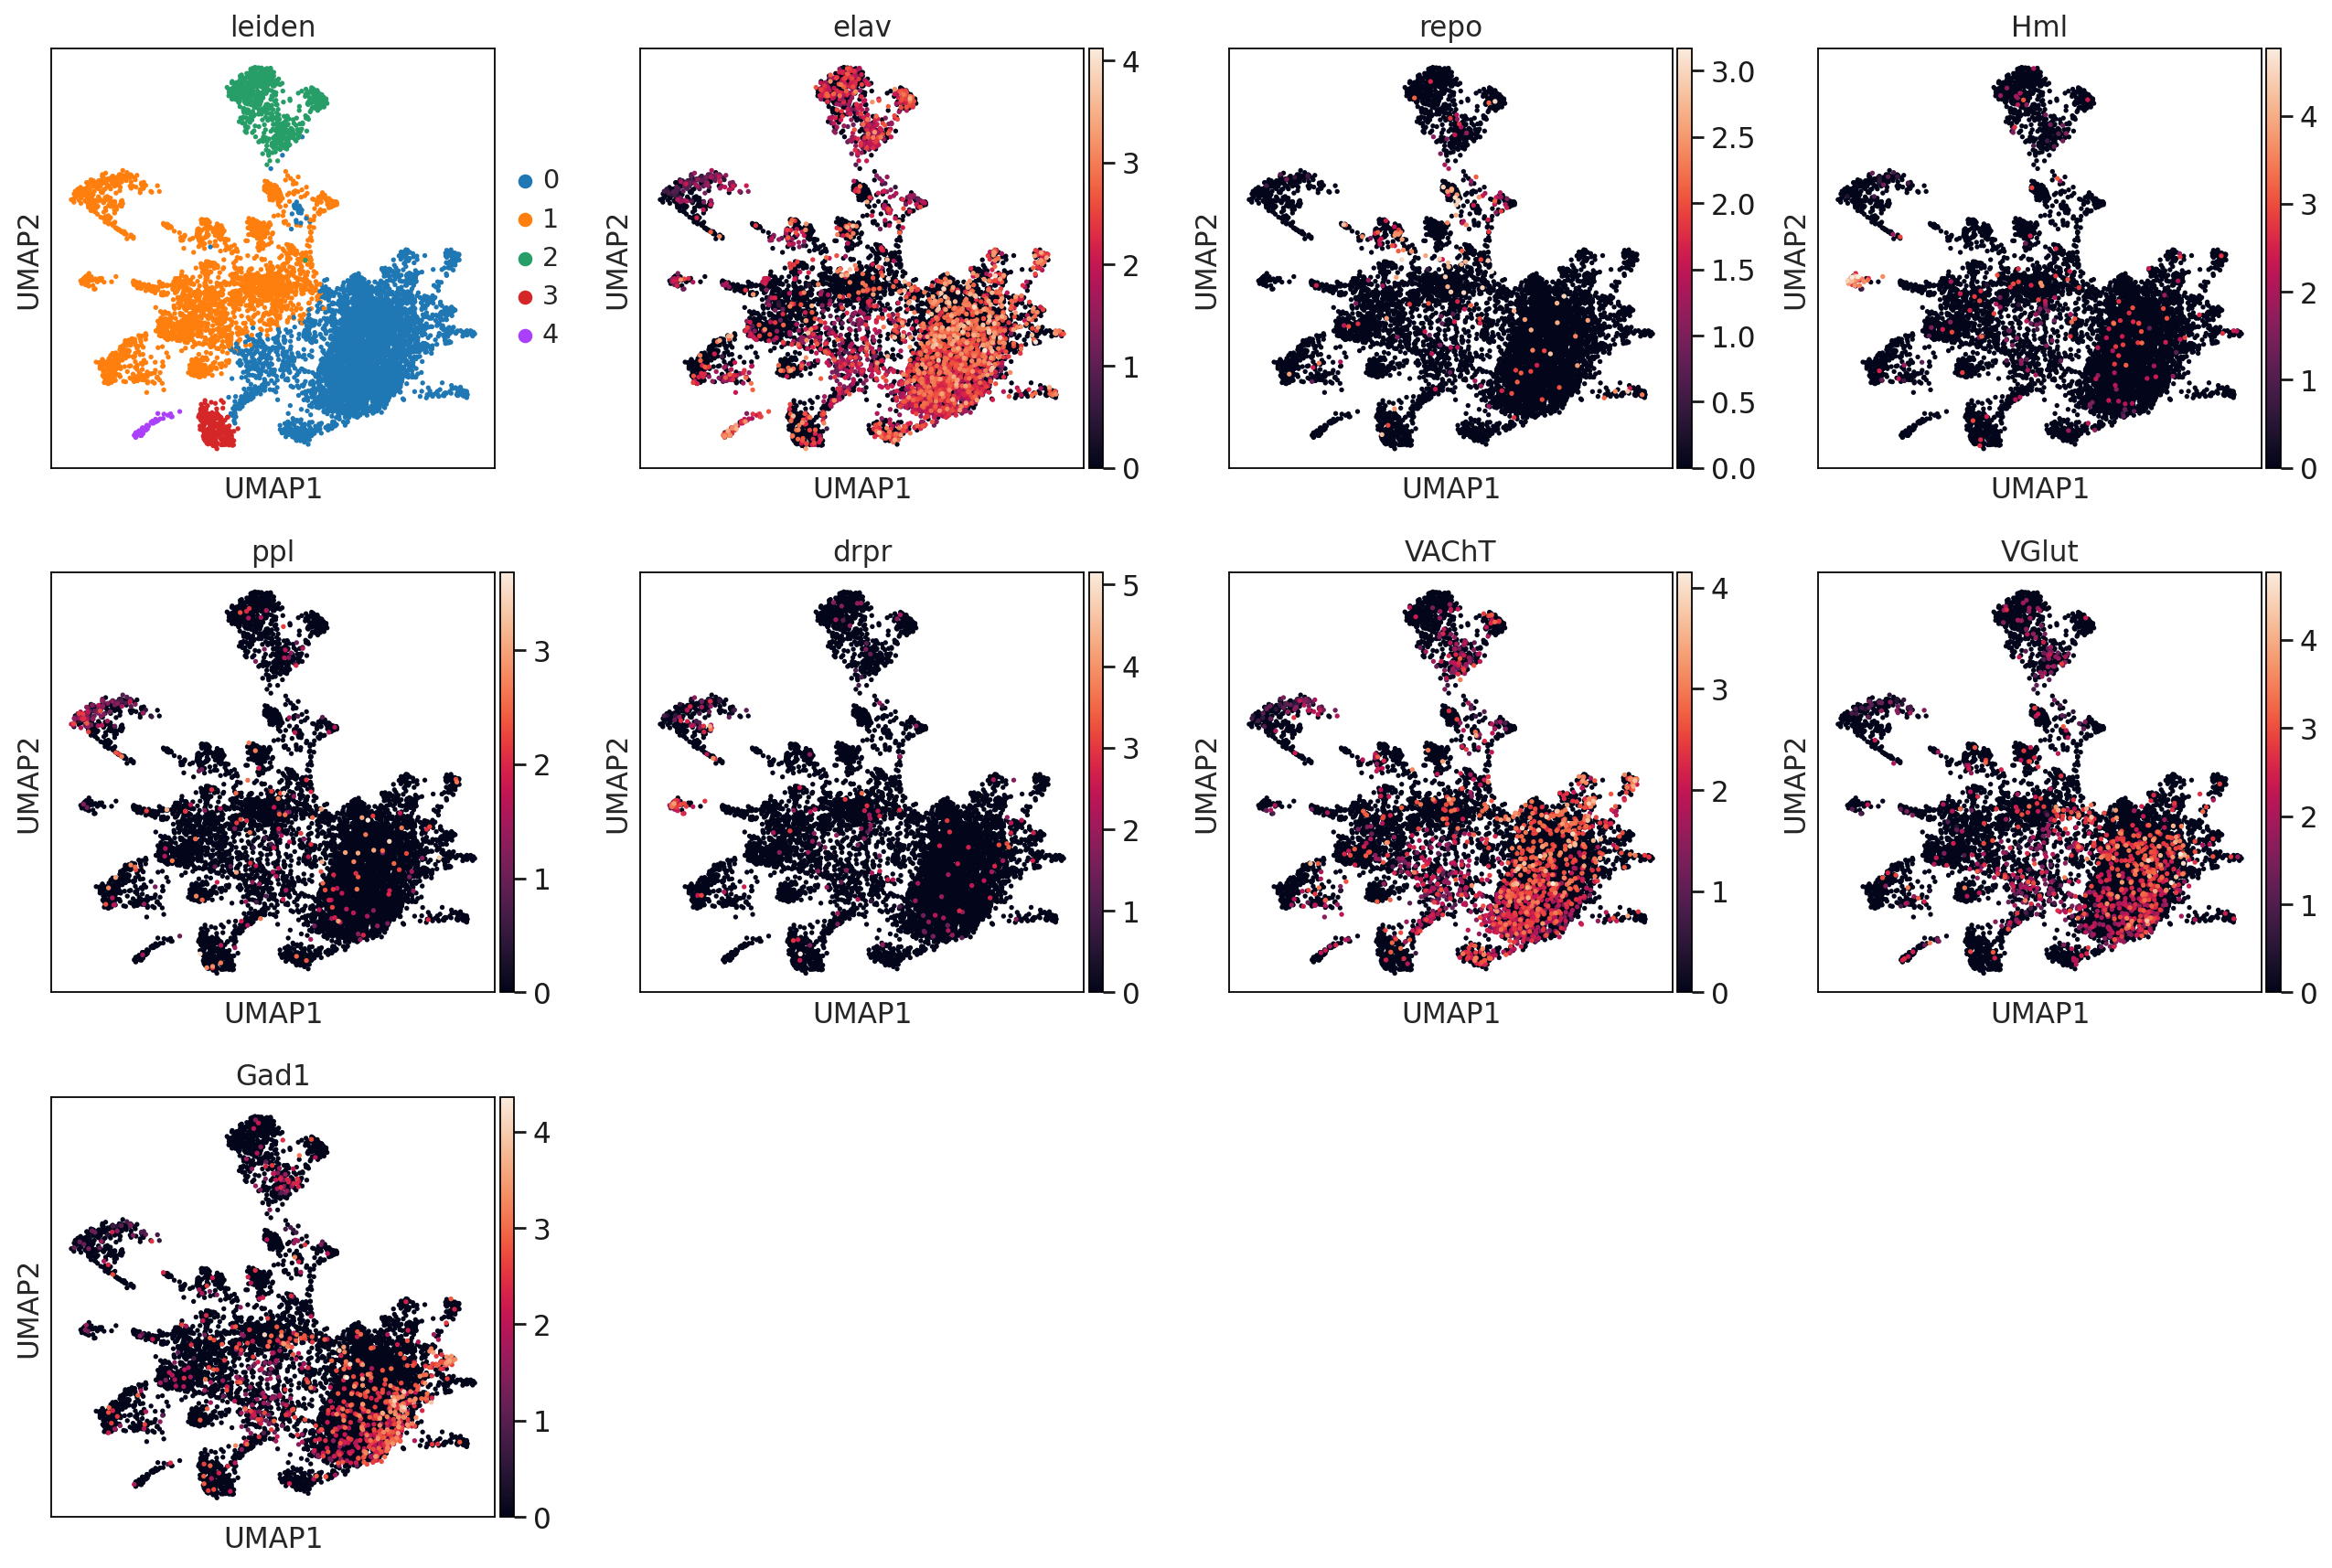

In [156]:
sc.pl.umap(drprnull_42d, color=["leiden","elav", "repo",  "Hml","ppl","drpr", "VAChT","VGlut","Gad1"], size=23)

In [129]:
drprnull_42d.write(outputfile)

## Find marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


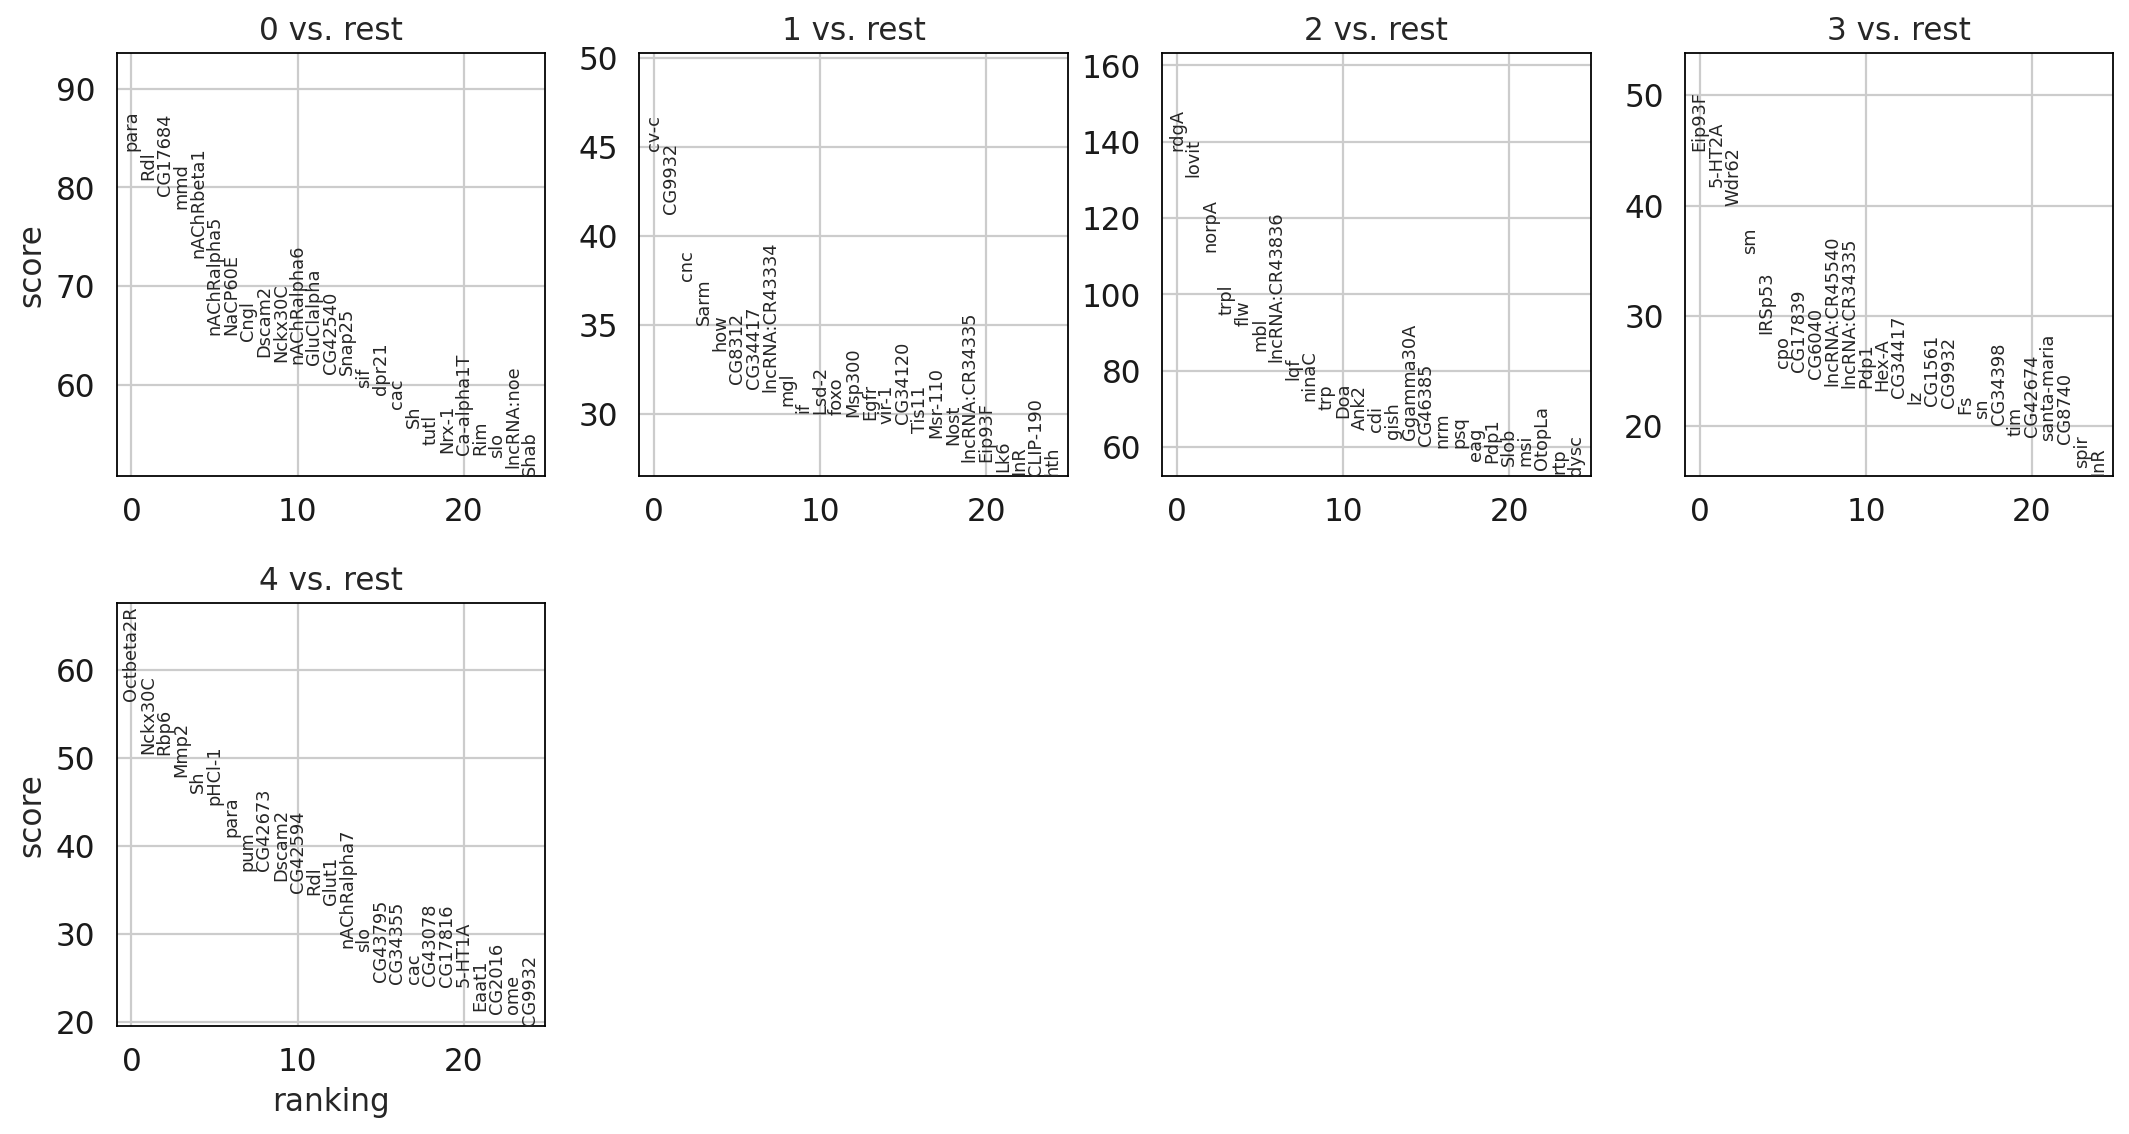

In [148]:
sc.tl.rank_genes_groups(drprnull_42d, "leiden", method="t-test")
sc.pl.rank_genes_groups(drprnull_42d, n_genes=25, sharey=False)

ranking genes


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


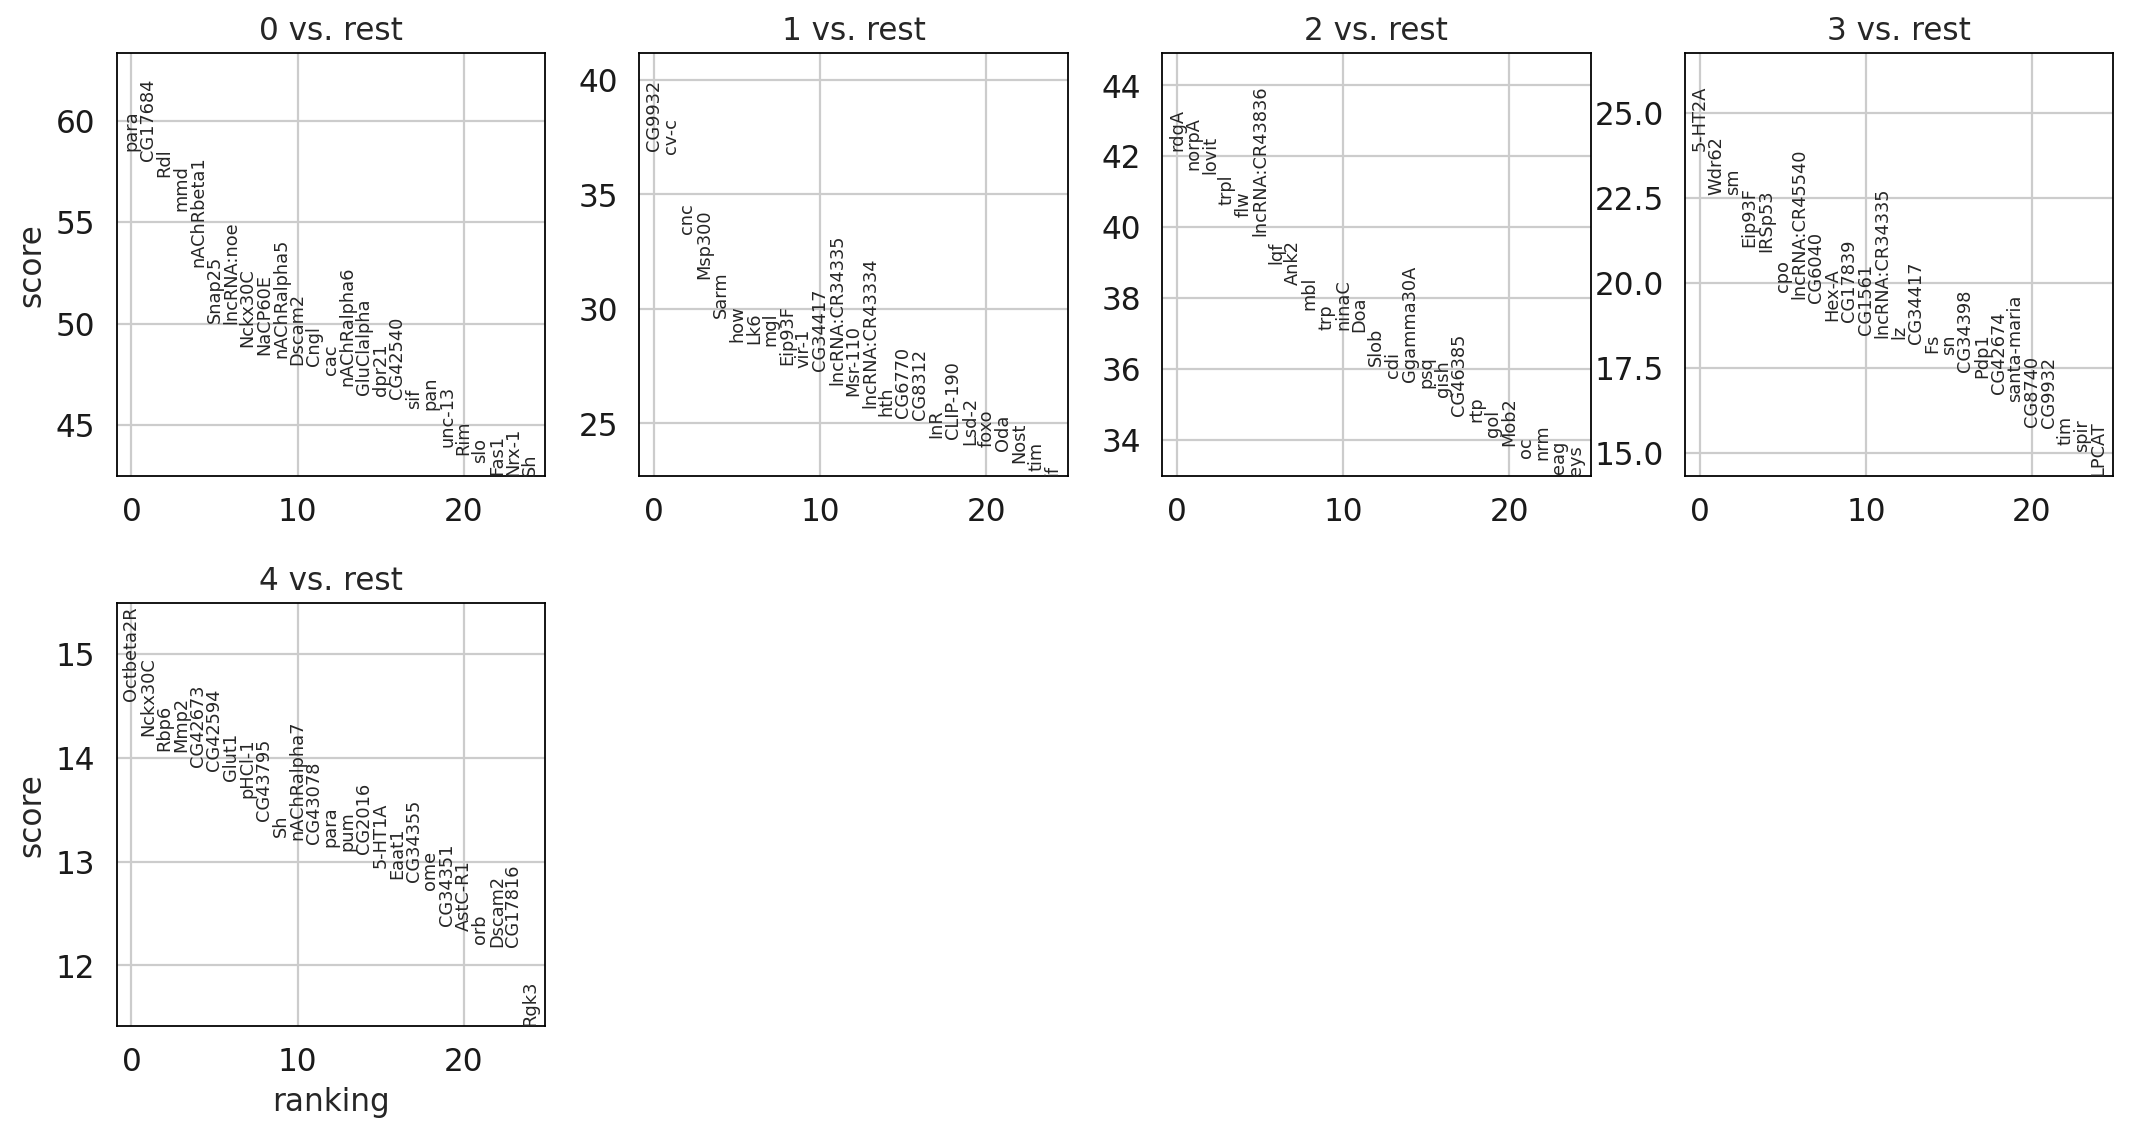

In [149]:
sc.tl.rank_genes_groups(drprnull_42d, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(drprnull_42d, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:02)


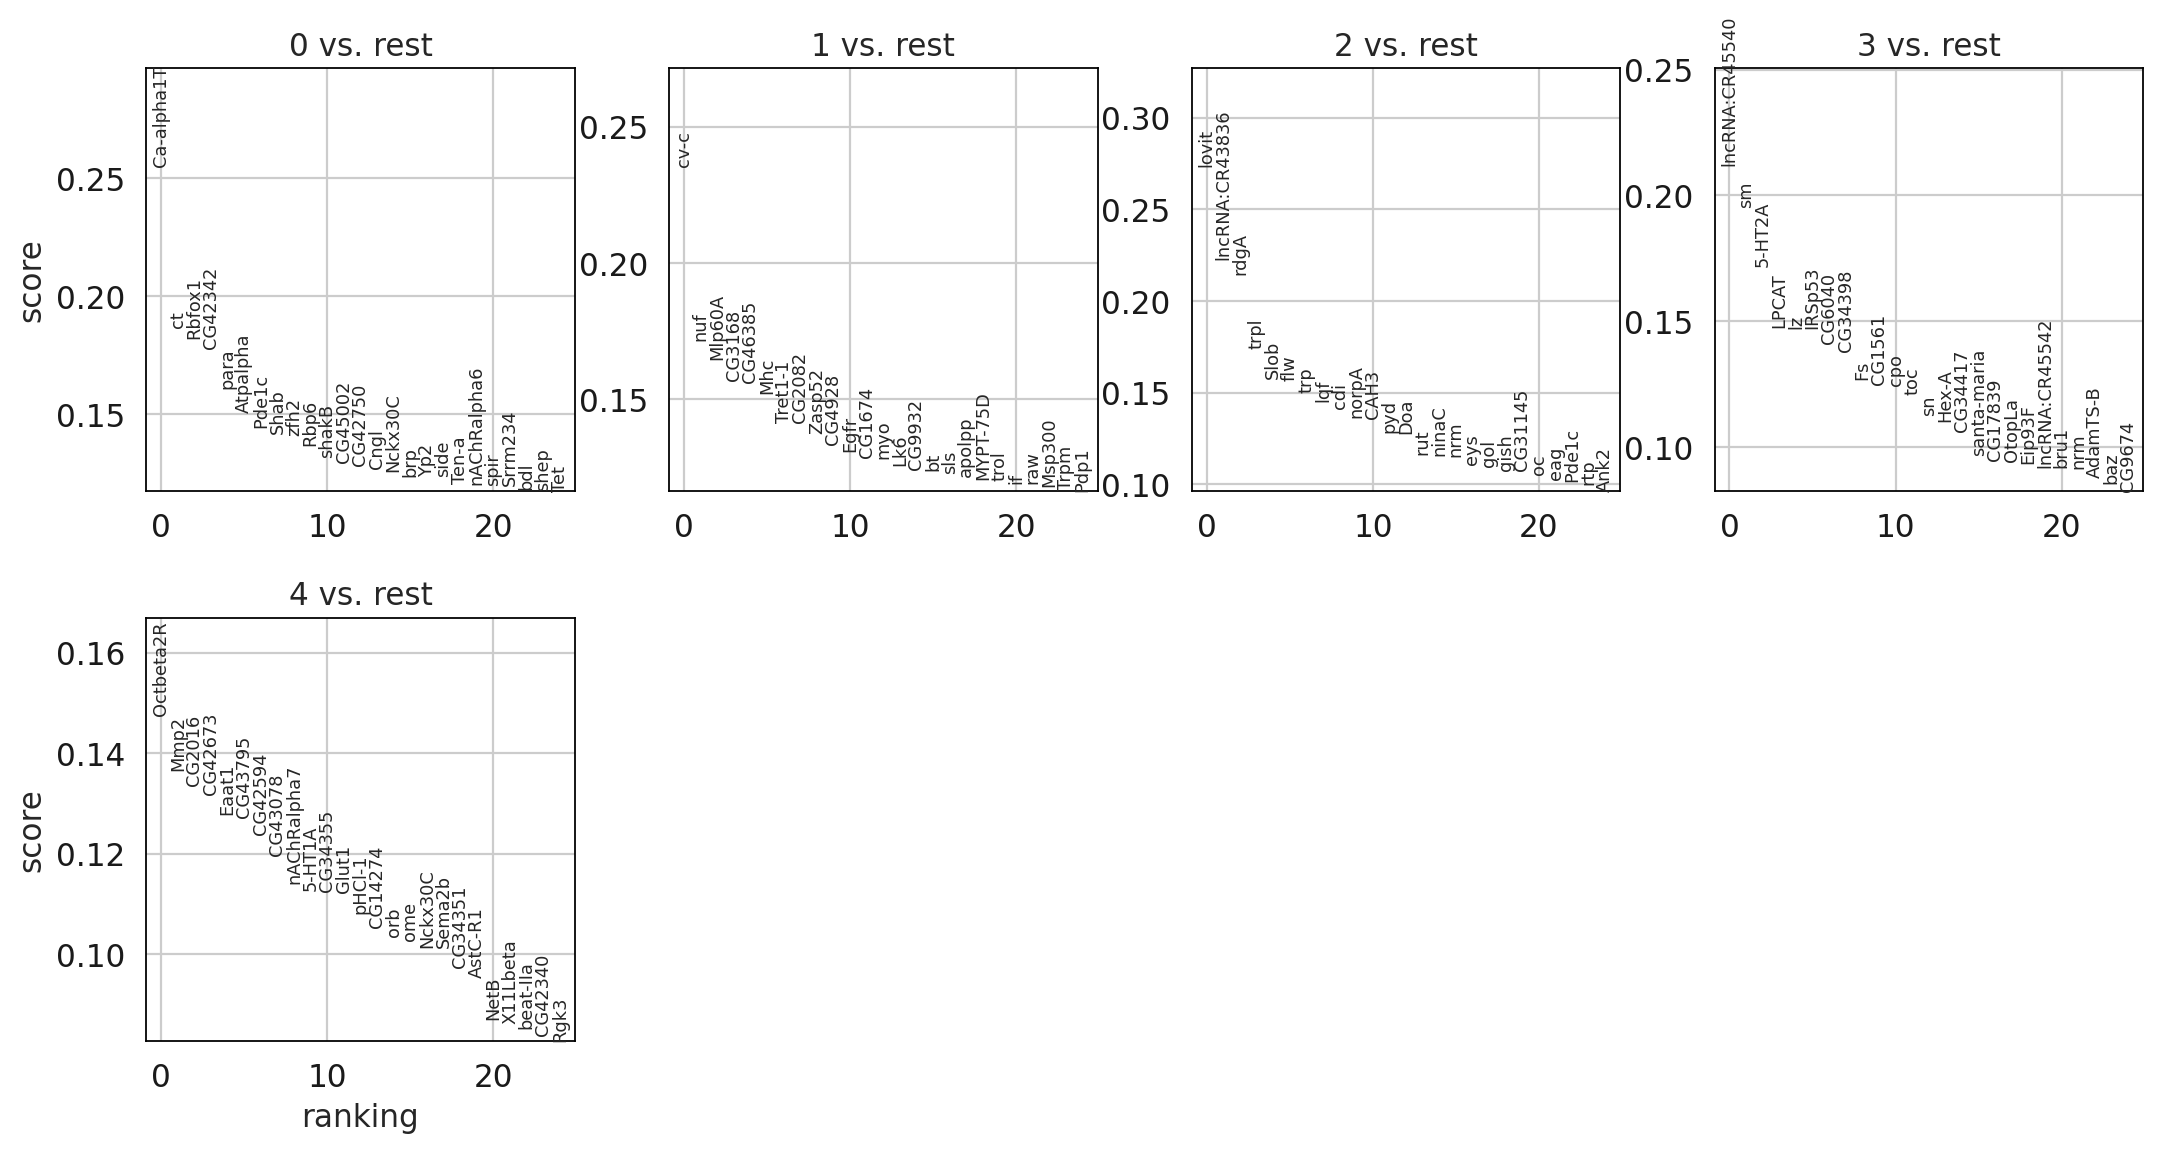

In [150]:
sc.tl.rank_genes_groups(drprnull_42d, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(drprnull_42d, n_genes=25, sharey=False)

In [ ]:
drprnull_42d